***Анализ топ 250 фильмов по рейтингу IMDB***



Многие из нас любят посмотреть отличный фильм в свободное время. Задумывались вы о том, как что общего между ними. В этом проекте я проведу небольшой сравнительный анализ 250 лучших фильмов по скромному рейтингу IMDB.

Для начала импортируем все библиотеки, которые нам понадобятся.

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd

К сожалению IMDB запрещает парсить данные с его сайта, поэтому пришлось использовать данные выложенные на Википедии. Справедливост ради, рейтинг фильмов на Википедии полностью основан на рейтинге IMDB, поэтому качество исследования не страдает.

Используя веб скреппинг через BeautifulSoup мы спарсим данные со страницы Википедии со следующим URL: https://ru.wikipedia.org/wiki/250_лучших_фильмов_по_версии_IMDb

In [3]:
url = 'https://ru.wikipedia.org/wiki/250_лучших_фильмов_по_версии_IMDb'

# Отправляем GET-запрос к странице
response = requests.get(url)
soup = BeautifulSoup(response.content, 'html.parser')

# Используем CSS селектор для нахождения нужной таблицы
table = soup.select_one('#mw-content-text > div.mw-content-ltr.mw-parser-output > table:nth-child(10)')

После подключения к странице мы создаем новый датафрейм, в котором будем хранить информацию с таблицы в формате:

Рейтинг | Название фильма | Год выхода | Режиссер | Жанр

Поскольку в таблице в стоблце "Жанр" присутсвует несколько значений, мы будем брать только первое, чтобы немного упростить группировку фильмов по жанрам.

Также изменим тип данных в столбцах "Рейтинг" и "Год выхода" в int64.


In [4]:
# Создаем пустой DataFrame для хранения данных
columns = ['Position', 'Title', 'Year', 'Director', 'Genre']
data = pd.DataFrame(columns=columns)

# Парсим данные с сайта
rows = []
for row in table.find_all('tr')[1:]:
    cells = row.find_all('td')
    if len(cells) >= 5:
        position = cells[0].text.strip()
        title = cells[1].text.strip()
        year = cells[2].text.strip()
        director = cells[3].text.strip()
        genre = cells[4].text.strip().split(',')[0]  # Берем первый жанр
        rows.append({'Position': position, 'Title': title, 'Year': year, 'Director': director, 'Genre': genre})

data = pd.concat([data, pd.DataFrame(rows)], ignore_index=True)

# Преобразуем данные в нужные форматы
data['Year'] = pd.to_numeric(data['Year'], errors='coerce')
data['Position'] = pd.to_numeric(data['Position'], errors='coerce')

Наш датафрейм выглядит следующим образом:

In [5]:
print(data.head())

   Position                   Title  Year              Director     Genre
0         1       Побег из Шоушенка  1994        Фрэнк Дарабонт     драма
1         2           Крёстный отец  1972  Фрэнсис Форд Коппола  детектив
2         3           Тёмный рыцарь  2008       Кристофер Нолан    боевик
3         4         Крёстный отец 2  1974  Фрэнсис Форд Коппола  детектив
4         5  12 разгневанных мужчин  1957           Сидни Люмет  детектив


**Описательный анализ**

Сгруппируем все фильмы по жанрам и посмотрим какой жанр полюбился пользователям IMDB больше всего.

In [6]:
# Группировка по жанрам
genre_stats = data.groupby('Genre').size().reset_index(name='Count')
genre_stats = genre_stats.sort_values(by='Count', ascending=False)

Установим единый стиль для визуализации

In [7]:
# Установка стиля
sns.set(style="whitegrid")
plt.figure(figsize=(14, 7))

<Figure size 1400x700 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

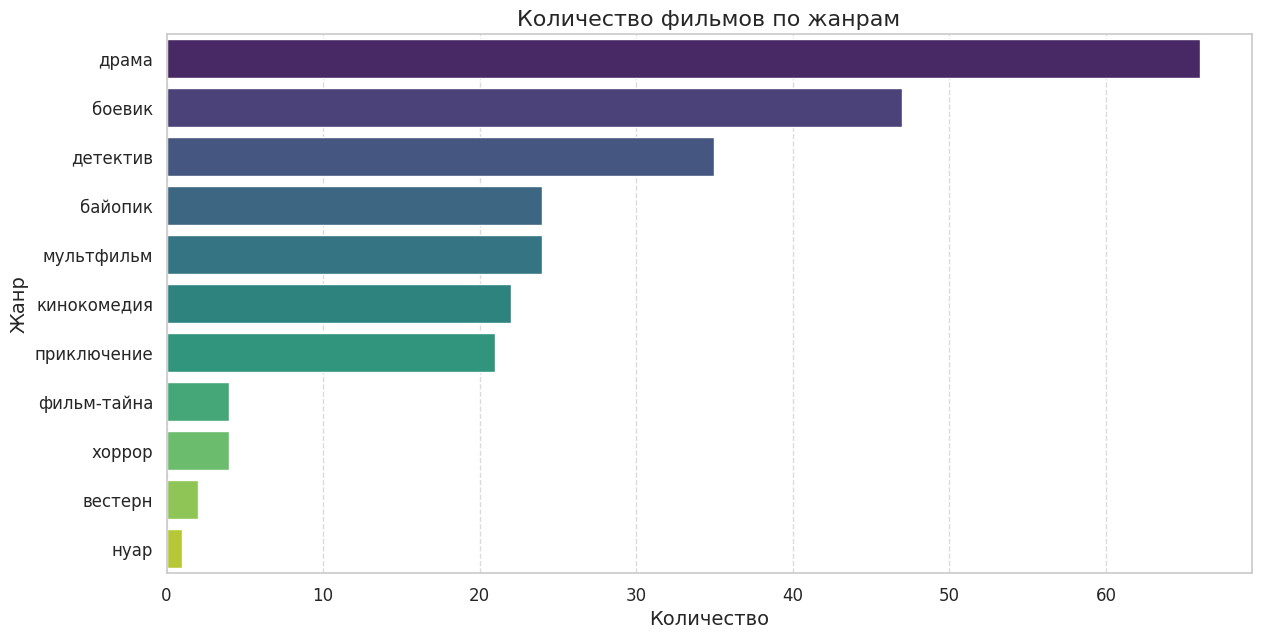

In [8]:
# Визуализация количества фильмов по жанрам
plt.figure(figsize=(14, 7))
sns.barplot(x='Count', y='Genre', data=genre_stats, palette='viridis', hue='Genre')
plt.title('Количество фильмов по жанрам', fontsize=16)
plt.xlabel('Количество', fontsize=14)
plt.ylabel('Жанр', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

Как мы видим, люди очень любят драму. Люди склонны наблюдать за терзанием других людей, если их это никак не касается.


Теперь посмотрим на режиссеров, которым удалось сделать наибольшее количество, которые понравились людям.

In [9]:
# Группировка по режиссерам и расчет количества фильмов
director_stats = data.groupby('Director').size().reset_index(name='Count')
director_stats = director_stats.sort_values(by='Count', ascending=False)


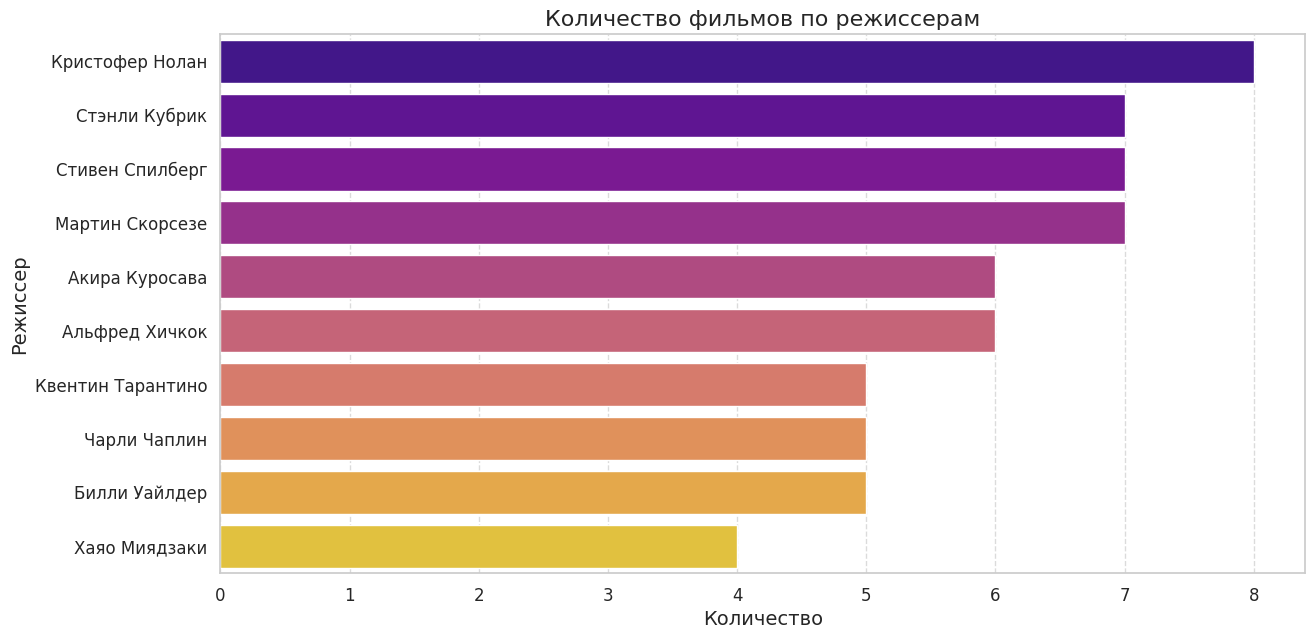

In [10]:
# Визуализация количества фильмов по режиссерам
plt.figure(figsize=(14, 7))
top_directors = director_stats.head(10)  # Топ-10 режиссеров
sns.barplot(x='Count', y='Director', data=top_directors, palette='plasma', hue='Director')
plt.title('Количество фильмов по режиссерам', fontsize=16)
plt.xlabel('Количество', fontsize=14)
plt.ylabel('Режиссер', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

Мы в лишний раз убедились, что шедевры Кристофера Нолана прошли проверку временем и стали любимыми для многих людей на нашей планете.

Сейчас давайте проанализируем, в какое время были выпущены самые успешные фильмы. Для этого сгруппируем фильмы по году выхода, и сделаем красивую визуализацию, использую seaborn и добавление аннотации.

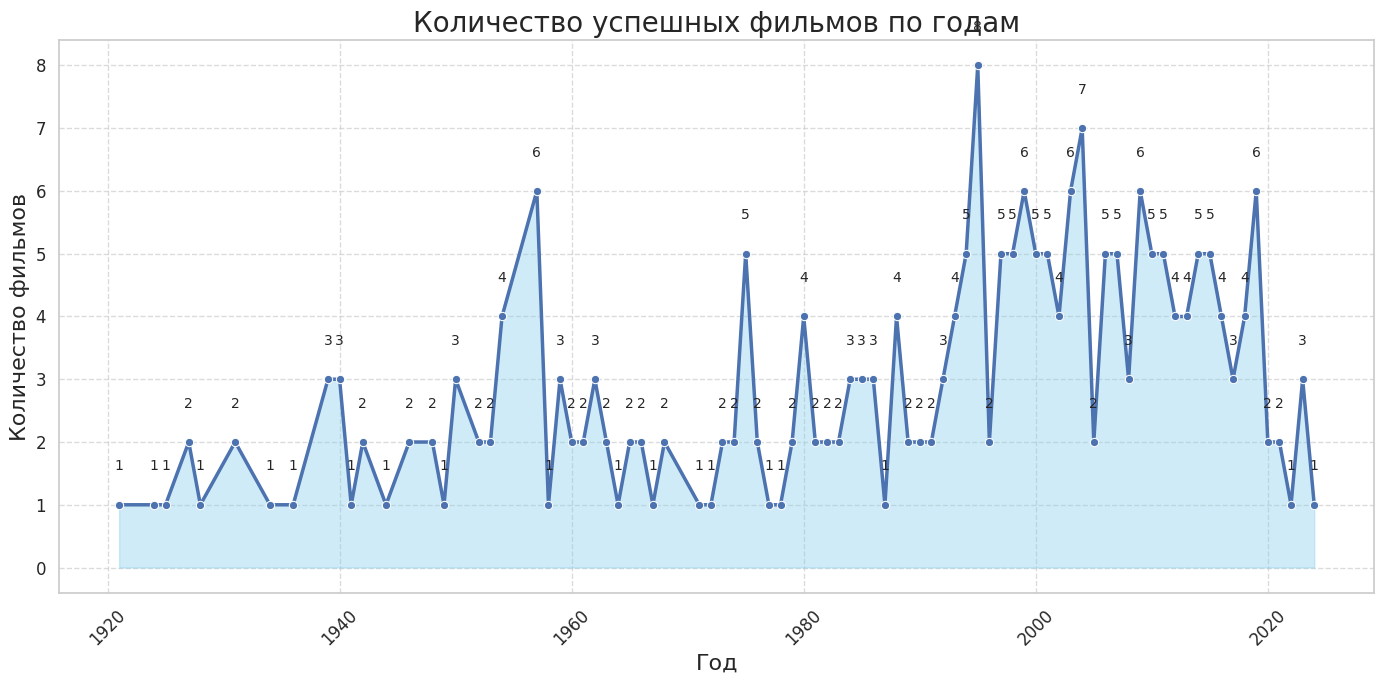

In [14]:
# Группируем данные по годам
yearly_counts = data.groupby('Year').size().reset_index(name='Count')

# Рисуем график
plt.figure(figsize=(14, 7))
sns.lineplot(x='Year', y='Count', data=yearly_counts, marker='o', color='b', linewidth=2.5)

# Добавляем дополнительные настройки для лучшей читаемости
plt.title('Количество успешных фильмов по годам', fontsize=20)
plt.xlabel('Год', fontsize=16)
plt.ylabel('Количество фильмов', fontsize=16)
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.fill_between(yearly_counts['Year'], yearly_counts['Count'], color="skyblue", alpha=0.4)

# Добавляем аннотации
for x, y in zip(yearly_counts['Year'], yearly_counts['Count']):
    plt.text(x, y + 0.5, f'{y}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()


Мы видим, что яркий пик мирового кинематографа пришелся на конец 90х. Хочется верить, что этому способствовало быстрое развитие графики и спец.эффектов.

Давайте посмотрим на эти данные под еще одним углом. Разберем какой жанр был наиболее популярным среди топ 250 лучших фильмов в разное время.

Чтобы сделать визуальный анализ более приятным, мы ограничимся лишь 5 самыми популярными жанрами в этоп рейтинге.

In [ ]:
# Ограничим количество жанров
top_genres = data['Genre'].value_counts().head(5).index.tolist()
filtered_data = data[data['Genre'].isin(top_genres)]

year_genre_counts = filtered_data.groupby(['Year', 'Genre']).size().reset_index(name='Count')

Построим наш красивый и приятный график

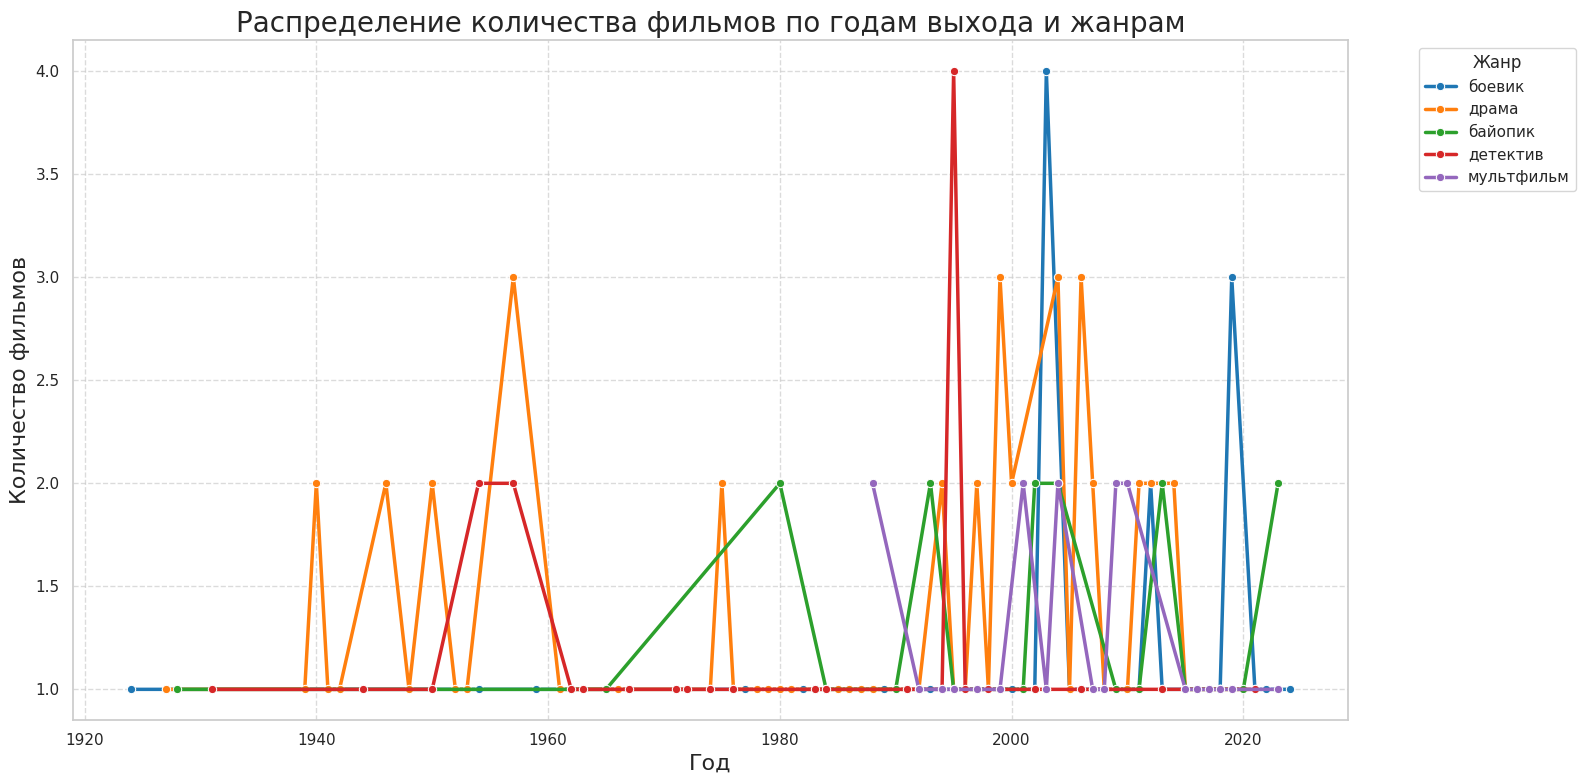

In [36]:
# Распределение количества фильмов по годам выхода и жанрам
plt.figure(figsize=(16, 8))
sns.lineplot(x='Year', y='Count', hue='Genre', data=year_genre_counts, marker='o', palette='tab10', linewidth=2.5)
plt.title('Распределение количества фильмов по годам выхода и жанрам', fontsize=20)
plt.xlabel('Год', fontsize=16)
plt.ylabel('Количество фильмов', fontsize=16)
plt.legend(title='Жанр', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

По графику можно сделать вывод, что драма стабильно пользуется популярностью в предпочтениях режиссеров и зрителей. А вот боевики и детективы имеют ярко выраженные пики популярности.

**Географический анализ**

Сейчас давайте проанализируем 250 лучших фильмов, но теперь уже по странам их производства. К сожалению, в нашем датафрейме нет информации для по поводу стран, поэтому нам придется еще раз воспользоваться парсингом.

Воспользуемся уже собранной статистикой по странам и количеству фильмов в топ 250 по IMDB. Для этого возьмем данные с сайте с URL:

https://250.took.nl/titles/country


Снова используем BeautifulSoup для подключения к странице и последующего парсинга данных с нее.

In [15]:
url = 'https://250.took.nl/titles/country'

# Отправляем GET-запрос к странице
response = requests.get(url)
soup = BeautifulSoup(response.content, 'html.parser')


Создаем новый датафрейм, в котором будем хранить все необходимую информацию в формате:

Страна | Количество фильмов в топ 250

In [16]:
# Создаем пустой DataFrame для хранения данных
columns = ['Country', 'Count']
countries = pd.DataFrame(columns=columns)
rows=[]


Переходим на страницу и парсим с нее данные. Поскольку они содержатся в таблице, нам достаточно найти необходимую таблицу и просто идти по ней.

In [18]:
# Найдем таблицу с данными
table = soup.find('table')

# Парсим данные с нее
for row in table.find_all('tr')[1:]:
    cells = row.find_all('td')
    if len(cells) >= 2:
        country = cells[0].text.strip()
        count = cells[1].text.strip()
        rows.append({'Country': country, 'Count': int(count)})

countries = pd.concat([countries, pd.DataFrame(rows)], ignore_index=True)

Заметим, что в таблице на сайте некоторые страны называются не так, как они называются в geopandas, поэтому эти значения не будут учтены. Для этого вручную изменим их название.

Также не забудем исключить страны, которые уже не существуют. В этом случае заменим "Soviet Union" на "Russia".

In [19]:
country_replacements = {
    'USA': 'United States of America',
    'UK': 'United Kingdom',
    'Soviet Union': 'Russia'
}
countries['Country'] = countries['Country'].replace(country_replacements)
excluded_countries = ['Czechoslovakia', 'East Germany', 'West Germany', 'Yugoslavia']
countries = countries[~countries['Country'].isin(excluded_countries)]

Давайте сделаем визуализацию найденных данных на карте мира. Для этого воспользуемся библиотекой geopandas. Сначала нанесем на карту географические границы, а потом совместим их с нашим датафреймом.

In [20]:
# Загрузим данные географических границ мира
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Объединим данные с географическими границами
world = world.merge(countries, how='left', left_on='name', right_on='Country')

<ipython-input-20-778faf803e53>:2: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


Изобразим полученные результаты на карте, предварительно установив стиль карты.

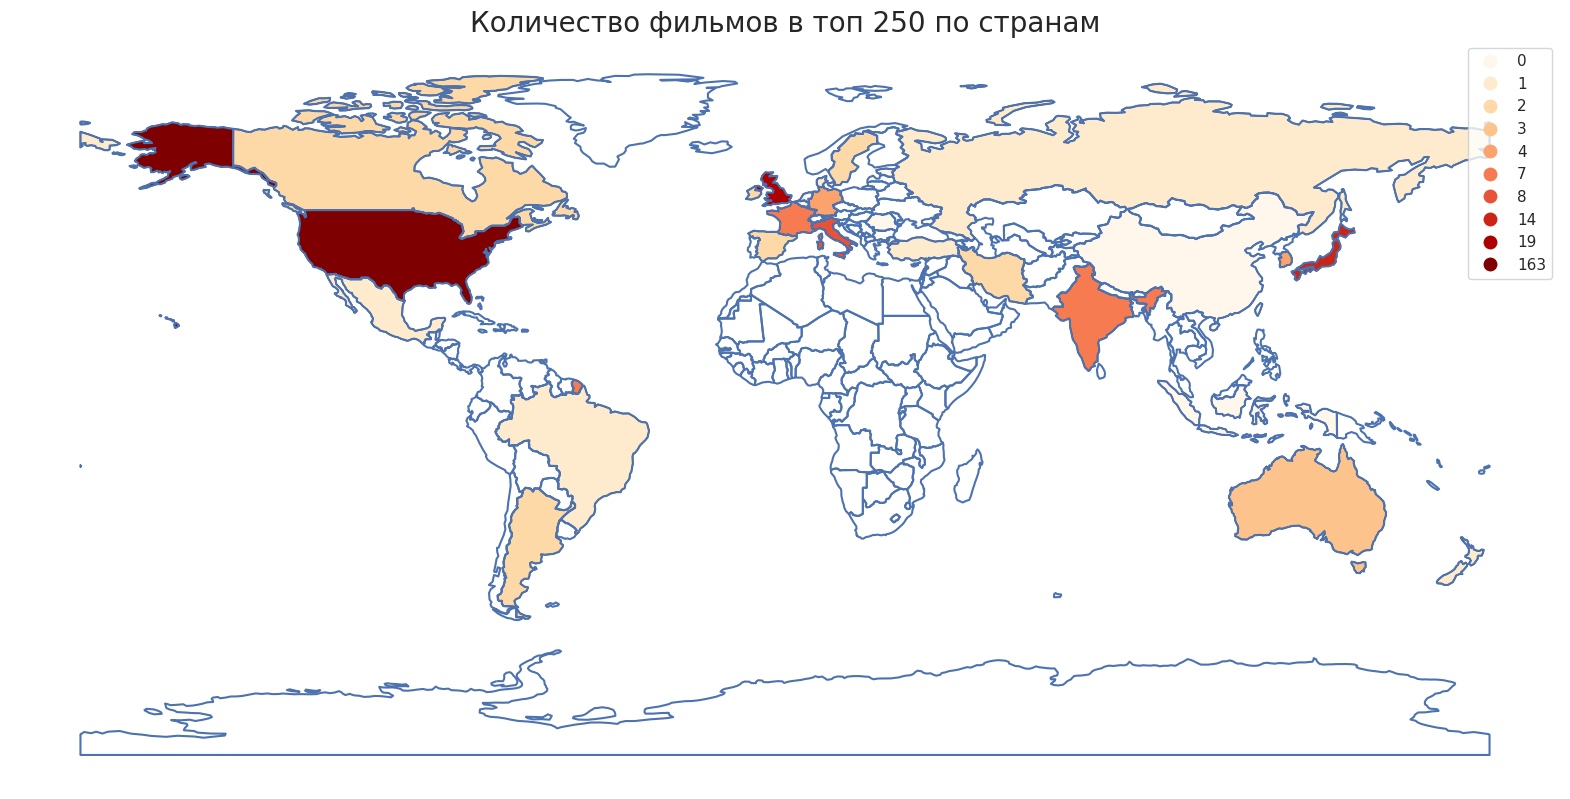

In [21]:
# Делаем карту опрятной и читаемой
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
world.boundary.plot(ax=ax)
world.plot(column='Count', ax=ax, legend=True, cmap='OrRd', edgecolor='black')
ax.set_title('Количество фильмов в топ 250 по странам', fontsize=20)
ax.set_axis_off()

plt.show()


Из предоставленной визуализации мы точно можем выделить США как основного поставщика отличных фильмов. Идея голливудских фильмов живет и продолжате радовать людей до сих пор. Во многом это связано с высоким уровнем образования актеров в этой стране, пока никакой другое государство не может похвастаться таким достижением.

***Вывод***

Мы под разными углами посмотрели на топ 250 лучших фильмов по версии IMDB. Посмотрели, какие жанры и режиссеры попадали в этот рейтинг. Проанализировали когда выходили наиболее успешные фильмы. Не забыли также и про географический анализ, который показал, что США все еще является лидером по производству наиболее крутых фильмов.